In [13]:
#Load Data
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression

por_attrs = pd.read_csv("https://raw.githubusercontent.com/dieulien/datamining/master/b_data_por.csv", sep = ',')
por_labels= pd.read_csv("https://raw.githubusercontent.com/dieulien/datamining/master/b_categorized_por_result.csv", sep = ',',header=None)
por_attrs = por_attrs.iloc[:,1:].values
por_labels = por_labels.iloc[:,1:].values


#train-test split for drawing curve, visulization of tree etc.
por_attrs_train, por_attrs_test, por_labels_train, por_labels_test = train_test_split(por_attrs, por_labels, test_size=0.33, random_state=42)


models = ["KNN", "Naive-Bayes","Decision Tree", "Logistic Regression", "SVM"]
cross_val_scores = []


In [14]:
# KNN
def find_best_k(attrs, labels):
    score_list = []
    score_mean_list = []
    k_list = []
    optimal_k = 1

    for i in range(1,31):
        knn = KNeighborsClassifier(n_neighbors = i, metric="euclidean")
        scores = cross_val_score(knn, attrs, labels, scoring = 'f1', cv = 10)
        mean = scores.mean()
        score_list.append(scores)
        score_mean_list.append(mean)
        k_list.append(i)
        if score_mean_list[i-1] > score_mean_list[optimal_k - 1]:
            optimal_k = i

    score_df = pd.DataFrame(score_list).transpose()
    score_df.columns = [k_list]

    return optimal_k

optimal_k = find_best_k(por_attrs, por_labels)

knn = KNeighborsClassifier(n_neighbors = optimal_k, metric="euclidean")
scores = cross_val_score(knn, por_attrs, por_labels, scoring = 'f1', cv = 10)
score = scores.mean()
cross_val_scores.append(score)

print("optimal k is: " + str(optimal_k))
print("Cross Validation Score: " + str(score))

optimal k is: 25
Cross Validation Score: 0.6007266563882211


In [15]:
# Naive-Bayes
gau = GaussianNB()
scores = cross_val_score(gau, por_attrs, por_labels, scoring = 'f1', cv = 10)
score = scores.mean()
cross_val_scores.append(score)

print("Cross Validation Score: " + str(score))

Cross Validation Score: 0.6857381547045835


In [16]:
# Decision Tree
def find_best_depth(attrs, labels):
    scores_tr = []
    scores_mean_tr = []
    optimal_depth = 1
    depth_values = []
    for d in range(1, 31):
        tr = tree.DecisionTreeClassifier(max_depth = d)
        cross_score_tr = cross_val_score(tr, attrs, labels, cv=10, scoring='f1')
        scores_tr.append(cross_score_tr)
        scores_mean_tr.append(cross_score_tr.mean())
        depth_values.append(d)
        if scores_mean_tr[d-1] > scores_mean_tr[optimal_depth-1]:
            optimal_depth = d
    return optimal_depth

optimal_depth = find_best_depth(por_attrs, por_labels)

tr = tree.DecisionTreeClassifier(max_depth = optimal_depth)
cross_score_tr = cross_val_score(tr, por_attrs, por_labels, cv=10, scoring='f1')
score_mean_tr = cross_score_tr.mean()
cross_val_scores.append(score_mean_tr)
score_mean_tr

print("optimal depth is: " + str(optimal_depth))
print("Cross Validation Score: " + str(score_mean_tr))

optimal depth is: 2
Cross Validation Score: 0.6694747425872746


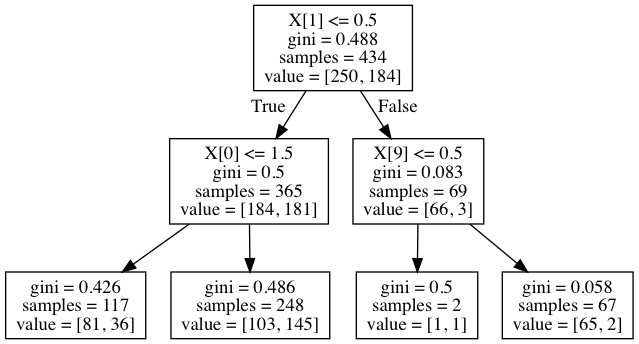

In [17]:
# show result in graph -- decision tree visualization
from IPython.display import Image 
from graphviz import Graph
import graphviz
import pydotplus

dec_tr = tree.DecisionTreeClassifier(max_depth = optimal_depth)
dec_tr.fit(por_attrs_train, por_labels_train)
tree_graphviz = tree.export_graphviz(dec_tr, out_file=None)  

tree_graph = pydotplus.graph_from_dot_data(tree_graphviz)
Image(tree_graph.create_png())

In [18]:
#Logistic Regression
log_R = LogisticRegression()

cross_score_log = cross_val_score(log_R, por_attrs, por_labels, cv=10, scoring='f1')
scores_mean = cross_score_log.mean()
cross_val_scores.append(scores_mean)

print("Cross Validation Score: " + str(scores_mean))

Cross Validation Score: 0.6460335645368408


In [19]:
#SVM

#optimizing parameters for SVM
def find_opt_svm(attrs, labels):
    best_lam = 1
    best_gam = 1
    best_acc = -1
    
    for Lambda in [0.0001, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 100.0]:
        for Gamma in [0.0001, 0.01, 0.1, 1.0, 10.0, 1000.0]:
            
            mysvm = svm.SVC(probability=True, C=1/Lambda, gamma=Gamma)        
            cross_score = cross_val_score(mysvm, attrs, labels, cv=10, scoring='f1')
            acc = cross_score.mean()
            
            if (acc > best_acc):
                best_lam = Lambda
                best_gam = Gamma
                best_acc = acc
    
    return best_lam, best_gam
                    
lam, gam = find_opt_svm(por_attrs, por_labels)

mysvm = svm.SVC(C = 1 / lam, gamma=gam,probability=True)
scores = cross_val_score(mysvm, por_attrs, por_labels, scoring = 'f1_macro', cv = 10)
score = scores.mean()
cross_val_scores.append(score)
score

print("optimal C is: " + str(1/lam))
print("optimal Gamma is: " + str(gam))
print("Cross Validation Score: " + str(score))

optimal C is: 100.0
optimal Gamma is: 0.01
Cross Validation Score: 0.6795984022657293


In [22]:
cross_val_scores.reverse()

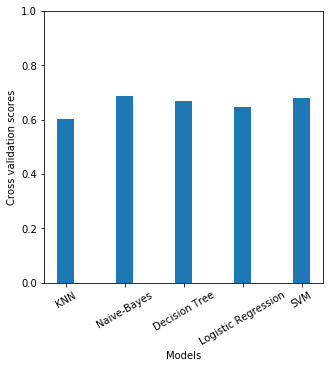

[0.6007266563882211,
 0.6857381547045835,
 0.6694747425872746,
 0.6460335645368408,
 0.6795984022657293]

In [23]:
#cross_val_scores = cross_val_scores[::-1]
index = np.arange(len(models))
plt.figure(figsize = (5,5))
plt.bar(index, cross_val_scores ,width = 0.3)
plt.xlabel('Models', fontsize=10)
plt.ylim(0.0, 1.0)
plt.ylabel('Cross validation scores', fontsize=10)
plt.xticks(index, models, fontsize=10, rotation = 30)
plt.show()

cross_val_scores

In [24]:
def draw_roc(model, name, features_test, labels_test):
    model_prob = model.predict_proba(features_test)
    fpr, tpr, thresholds = metrics.roc_curve(labels_test, model_prob[:,1], pos_label=1, sample_weight=None)
    plt.plot(fpr,tpr,linewidth=2.0, label = name)

In [25]:
def pre_rec_acc(model, name, features_test, labels_test):
    predictions_test = model.predict(features_test)
    print("Model: ", name)
    print("Precision: ", metrics.precision_score(labels_test,predictions_test))
    print("Recall: ", metrics.recall_score(labels_test,predictions_test))
    print("Accuracy: ", metrics.accuracy_score(labels_test,predictions_test), '\n')

In [26]:
knn.fit(por_attrs_train,por_labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform')

In [27]:
gau.fit(por_attrs_train, por_labels_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [28]:
tr.fit(por_attrs_train, por_labels_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [29]:
log_R.fit(por_attrs_train, por_labels_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [30]:
mysvm.fit(por_attrs_train, por_labels_train)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [31]:
pre_rec_acc(knn, 'kNN', por_attrs_test, por_labels_test)
pre_rec_acc(gau, 'Naive Bayes', por_attrs_test, por_labels_test)
pre_rec_acc(tr, 'Decision Tree',por_attrs_test, por_labels_test)
pre_rec_acc(log_R, 'Logistic Regression',por_attrs_test, por_labels_test)
pre_rec_acc(mysvm, 'SVM', por_attrs_test, por_labels_test)

Model:  kNN
Precision:  0.6190476190476191
Recall:  0.7065217391304348
Accuracy:  0.6883720930232559 

Model:  Naive Bayes
Precision:  0.5263157894736842
Recall:  0.9782608695652174
Accuracy:  0.6139534883720931 

Model:  Decision Tree
Precision:  0.5289855072463768
Recall:  0.7934782608695652
Accuracy:  0.6093023255813953 

Model:  Logistic Regression
Precision:  0.638095238095238
Recall:  0.7282608695652174
Accuracy:  0.7069767441860465 

Model:  SVM
Precision:  0.6126126126126126
Recall:  0.7391304347826086
Accuracy:  0.6883720930232559 



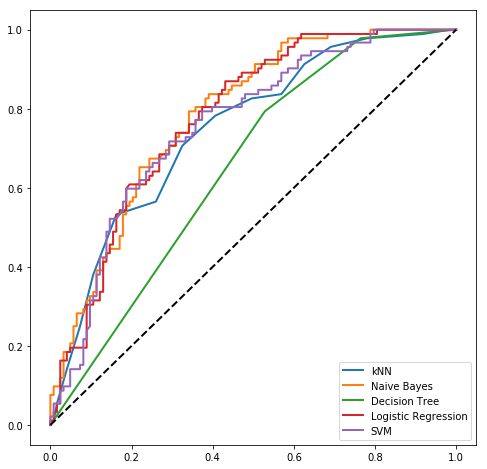

In [32]:
plt.figure(figsize=(8,8))
draw_roc(knn, 'kNN', por_attrs_test, por_labels_test)
draw_roc(gau, 'Naive Bayes', por_attrs_test, por_labels_test)
draw_roc(tr, 'Decision Tree',por_attrs_test, por_labels_test)
draw_roc(log_R, 'Logistic Regression',por_attrs_test, por_labels_test)
draw_roc(mysvm, 'SVM', por_attrs_test, por_labels_test)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

In [33]:
# Linear Regression
from sklearn.linear_model import LinearRegression

por_results= pd.read_csv("https://raw.githubusercontent.com/dieulien/datamining/master/b_por_result.csv", sep = ',',header=None)
por_results = por_results.iloc[:,1:].values

por_attrs_train, por_attrs_test, por_results_train, por_results_test = train_test_split(por_attrs, por_results, test_size=0.33, random_state=42)


# This creates a LinearRegression object
lm = LinearRegression(n_jobs=1)
lm.fit(por_attrs_train, por_results_train.flatten())

print('Estimated intercept coefficient:', lm.intercept_)
print('Number of coefficients:', len(lm.coef_))


lm.coef_

Estimated intercept coefficient: 8.577915208111673
Number of coefficients: 10


array([ 4.15741537e-01, -1.65800594e+00,  1.56614048e-01,  1.90232880e+00,
       -9.85864510e-04,  9.11867743e-02, -1.72131842e-01, -1.96214863e-01,
       -9.32386389e-02,  2.48490525e-01])

Text(0.5,1,'Actual Score vs Predicted Scores: $Y_i$ vs $\\hat{Y}_i$')

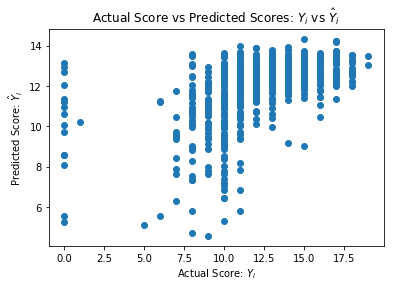

In [34]:
plt.scatter(por_results.flatten(), lm.predict(por_attrs))
plt.xlabel("Actual Score: $Y_i$")
plt.ylabel("Predicted Score: $\hat{Y}_i$")
plt.title("Actual Score vs Predicted Scores: $Y_i$ vs $\hat{Y}_i$")

In [35]:
rss = np.sum((por_results_test.flatten() - lm.predict(por_attrs_test)) ** 2)
mseFull = np.mean((por_results_test.flatten() - lm.predict(por_attrs_test)) ** 2)

print("Residual Sum of Squares = RSS = "+ str(rss))
print("Mean Squared Error = MSE = "+ str(mseFull))

Residual Sum of Squares = RSS = 1623.6325891042657
Mean Squared Error = MSE = 7.551779484205887
